# Introduction
The nearest neighbour classifier is a non parametric classification algorithm and has good performance in several applications. Both the memory and time complexity of prediction for the nearest neighbour classifier is dependent on the size of the prototype set. Prototype selection is the process of replacing the training set with a carefully chosen set of prototypes to speed up prediction while trying to retain good performance. Here the goal is to propose a method for prototype selection and evaluate it on a practical dataset.     
First we go through a brief description of the method and then present a more detailed description of the cost function in the next section to understand the method better. A form for $p(X \mid y,S)$ is assumed (S is the set of prototypes, X denotes the training examples and y the training labels) where the probability of each point depends only on its nearest neighbor from the prototype set having the same label. Using this assumption, we attempt to maximize $f(S) = \log\lbrack p(S \mid X,y) \rbrack$  to find the maximum aposteriori set of prototypes $S^{*}$. Although this is a combinatorial optimization problem, we observe that f(S) is a submodular, monotone function. For this class of functions, approximate greedy inference has been both practically and theoretically shown to be useful. Hence we use a greedy algorithm to maximize f(S) to obtain an approximation $S$ to the maximum aposterior solution $S^{*}$.  

# Description of cost function
We take a more detailed look at the cost function in order to better understand the method. For some subset S of the input examples, let us consider the posterior probability of S.
$$p(S | X,y) ∝ p(X | y,S)p(y | S)p(S)$$  
$$\implies \log \lbrack p(S | X, y) \rbrack = \log p(X | y, S)  + \log p(y | S)  + \log p(S)  + c$$  
where c is a constant. We maximize this function assuming a specific form p(X | y,S) that satisfies two main conditions 
* It accurately captures the requirements for good classification of a nearest neighbour classifier
* The resulting cost function is submodular

To do this, we assume that the probability of a feature vector is related to the nearest neighbor which has the same label as that feature vector. Specifically, we assume
$$p(X \mid y,S) = \prod_{i} max_{r\in S_{y_{i}}}e^{-\alpha ||x_{i} - r||_{2}^2}$$
where $S_{y_{i}}$ represents the subset of $S$ with label equal to $y_{i}$. We also assume that the probability of any prototypes set is proportional to $e^{-\beta |S|}$. This allows us to tradeoff the size of the prototypes set to the performance of the classifier by adjusting the value of $\beta$.

Substituting these in and making rearrangements, we get the cost function

$$f(S) = \sum_{i} \log  \big\lbrack p(x_{i} \mid y_{i},S)\big\rbrack$$  
$$\implies f(S) = \sum_{i} \bigg\lbrack -min_{x_{k} \in S_{y_{i}}} \frac{||x_{i} - x_{k}||_{2}^{2}}{n} + \alpha \frac{\log \big\lbrack p(y_{i} \mid S) \big\rbrack }{n} \bigg\rbrack -\beta |S|$$
where $\alpha$ and $\beta$ are hyper-parameters, $p(y_{i} \mid S)$ is just the proportion of prototypes of label $y_{i}$ in set $S$ and n is the number of examples in the training set. This function can be shown to be submodular. The proof could be done for example by showing that each $p(x_{i} \mid y_{i},S)$ is submodular and hence the sum is submodular. 

# Data description
The MNIST dataset is used to demonstrate and evaluate the proposed method. A detailed description of the dataset can be found [here](http://yann.lecun.com/exdb/mnist/). The preprocessing done here is to scale the data between 0 and 1 and subsequently threshold at 0.5 and make the data binary. 

In [1]:
# Load the dataset
%matplotlib inline
import cPickle, gzip, numpy
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from itertools import chain
import copy
import random
import sys
import functools
import scipy.spatial.distance as distance
import math
import cProfile
import numpy as np
from multiprocess import Pool
from multiprocessing import Manager,Lock
import numpy as np
from collections import defaultdict
from scipy.spatial.distance import hamming
import heapq
from collections import namedtuple
import unittest
import sklearn.metrics as metrics
import os
import pandas as pd
import sys

f = gzip.open('mnist.pkl.gz', 'rb')
train_set, valid_set, test_set = cPickle.load(f)
f.close()

train_x = 1*(train_set[0]>0.5)
test_x = 1*(test_set[0]>0.5)
valid_x = 1*(valid_set[0]>0.5)

Now we define generic functions to perform submodular maximization greedily. The docstrings describe the functions in more detail. One optimization that significantly speeds up computation is lazy function evaluation.  It is described in more detail in my blog [here](http://shriramck.blogspot.com/2016/10/submodular-function-maximization-use.html). The functions are tested on a simple instance of the set cover problem. 

In [2]:
def fprime_manual(f,x,s,args = ()):
    """
    Manual calculation of marginal gain. If there is a optimal custom implementation
    this should be overidden by supplying the fprime argument. Similar in spirit to 
    numerical gradient calculation.
    
    Parameters:
    __________
    f: callable f(x,s,*args); the objective function
    x: element of input set to calculate marginal gain for
    args: tuple (optinal); additional arguments to be supplied to f
    
    Returns:
    _______
    Marginal gain for element x, set s for function f
    """
    
    "Checking if solution class has all required interfaces"
    if hasattr(s,"__len__") & hasattr(s,"append") & hasattr(s,"__contains__"):
        l = getattr(s,"__len__")
        ap = getattr(s,"append")
        in_func = getattr(s,"__contains__")
        
        if callable(l) & callable(ap) & callable(in_func):
            pass
        else:
            raise TypeError("Solution class improperly defined")
    else:
        raise TypeError("Solution class improperly defined")
    
    if x in s:
        return 0
    else:
        s_new = copy.deepcopy(s)
        s_current = copy.deepcopy(s_new)
        
        s_new.append(x)
        return f(s_new,*args) - f(s_current,*args)

def fmax_submodular(f,s,fprime = None,sopt = None,k=float("Inf"),verbose = False,args=()):
    
    """
    Maximize a submodular function using the greedy method.
    
    Parameters:
    __________
    s: set of elements, search is performed over the powerset P(s).
    f: callable f(x,*args)
    fprime: callable fprime(x,s);If not supplied, defaults to manual cauculation
    args: tuple (optional) additional arguments to be passed to f
    k: Cardinatlity constraint |S|<k is enforced
    sopt: Custom solution class. Must provide certain interfaces corresponding to basic set 
    operations such as append-set construction, len-set size, contains-membership testing
    
    Returns:
    _______
    sopt: Optimal set for f
    fopt: Value of the function at the optimal point
    """
    
    if fprime == None:
        fprime = lambda x,s: fprime_manual(f,x,s,args)
    
    "Checking if solution class has all required interfaces"
    if sopt == None:
        sopt = []
    elif hasattr(sopt,"__len__") & hasattr(sopt,"append") & hasattr(sopt,"__contains__"):
        l = getattr(sopt,"__len__")
        ap = getattr(sopt,"append")
        in_func = getattr(sopt,"__contains__")
        
        if callable(l) & callable(ap) & callable(in_func):
            pass
        else:
            raise TypeError("Solution class improperly defined")
    else:
        raise TypeError("Solution class improperly defined")
        
    fopt = 0

    #Populate the heap
    #p = Pool(8)
    #gens = (i for i in s)
    #heap_fprimes = p.map(lambda x: (-fprime(x,sopt),x),gens)
    #p.close()
    
    heap_fprimes = [(-fprime(x,sopt),x) for x in s]
    heapq.heapify(heap_fprimes)
    
    #print heap_fprimes
    
    while len(sopt)<k:
        x = heapq.heappop(heap_fprimes)
        x = (-fprime(x[1],sopt),x[1])

        while len(heap_fprimes)>0 and x[0]>heap_fprimes[0][0]:
            heapq.heappush(heap_fprimes,x)
            x = heapq.heappop(heap_fprimes)
            x = (-fprime(x[1],sopt),x[1])

        if x[0]>=0:
            break
        else:
            sopt.append(x[1])
            fopt += -x[0]
        if verbose:
            percent_progress = 100*float(len(sopt))/(float(k)-1)
            sys.stdout.write("\r%f%% done; Value of objective: %f" % (percent_progress,fopt))
           
    solution = namedtuple("solution",["sopt","fopt"])
    print "\n"
    return solution(sopt,fopt)

def set_cover(s):
	if len(s)==0:
		return 0
	else:
		return len(reduce(lambda x,y:x|y,s))+1

soln = fmax_submodular(set_cover,[{1,2},{1,3,4},{1,2,4,5,6},{7,8}],k = 4,verbose = True)
print soln

100.000000% done; Value of objective: 9.000000

solution(sopt=[set([1, 2, 4, 5, 6]), set([8, 7]), set([1, 3, 4])], fopt=9)


Below we define a custom solution class. We use this class to perform fast evaluations of the objective function and gradient by maintaining some state. 

In [3]:
class solution:
    
    def __init__(self,x,y):
        
        self.train_data = x
        self.train_labels = y
        self.label_mapping = defaultdict(list)
        self.distances = dict()
        self.solution = []
        self.data_currentdistances = [float(784)]*x.shape[0]
        self.solution_sizes = defaultdict(int)
        self.distance_matrices = dict()
        self.index_map = dict()
        
        for index,label in enumerate(train_set[1]):
            self.label_mapping[label].append(index)
            self.index_map[index] = len(self.label_mapping[label])-1
        
        for label in self.label_mapping:
            label_set = self.label_mapping[label]
            self.distance_matrices[label] = np.inner(x[label_set,],1-x[label_set,]) + np.inner(1-x[label_set,],x[label_set,])
            
    def append(self,ind):
        delta = 0
        if ind in self:
            return delta
        else:
            for matrix_index,point_index in enumerate(self.label_mapping[self.train_labels[ind]]):
                new_dist = self.distance_matrices[self.train_labels[ind]][self.index_map[ind],matrix_index]
                new_pdist = min(self.data_currentdistances[point_index],new_dist)
                delta += self.data_currentdistances[point_index] - new_pdist
                self.data_currentdistances[point_index] = new_pdist
            self.solution.append(ind)
            self.solution_sizes[self.train_labels[ind]] += 1
            return delta
    
    def clear_solution(self):
        self.solution = []
        self.data_currentdistances = [float(784)]*self.train_data.shape[0]
        self.solution_sizes = defaultdict(int)
        return True
        
    def __repr__(self):
        return str(self.solution)
    
    def __len__(self):
        return len(self.solution)
    
    def __contains__(self,item):
        return item in self.solution

#Getting the solution construction profile    
s = solution(train_x,train_set[1])

The gradient and objective function for the nearest neighbour classifier is defined based on the solution class defined previously. A predict function to output classes for test datasets is also defined. Using the numerical fprime calculation method, the grad function is checked to ensure correctness. This is similar to check grad often performed when implementing gradients in machine learning applications.

In [9]:
def grad(ind,self,alpha = 0,beta = 0):
   
    delta = 0
    if ind in self:
        return 0
    else:        
        for matrix_index,point_index in enumerate(self.label_mapping[self.train_labels[ind]]):
            new_dist = self.distance_matrices[self.train_labels[ind]][self.index_map[ind],matrix_index]
            delta += self.data_currentdistances[point_index] - min(self.data_currentdistances[point_index],new_dist)   
            if self.solution_sizes[self.train_labels[ind]] != 0:
                delta += alpha*math.log( (self.solution_sizes[self.train_labels[ind]]+1)/self.solution_sizes[self.train_labels[ind]] )
        
        delta = delta/len(self.train_labels) - beta
         
        if len(self.solution)>0:
            delta += alpha*math.log( float(len(self.solution))/(len(self.solution) + 1) )
        
        return delta

def objective_function(s,alpha = 0,beta = 0):
    """
    Arguments:
    _________
    s represents the dictionary containing the list of prototypes for each label
    """
    cost = -sum(s.data_currentdistances)
     
    for label in s.train_labels:
        try:
            cost += alpha*math.log(s.solution_sizes[label]/float(len(s.solution)))
        except ValueError:
            return float("-Inf")
            
    cost = cost/float(s.train_data.shape[0]) - beta*len(s.solution)
    
    return cost

def predict(sol,test_data):
    
    s = np.array(sol.solution)
    distances = np.dot(1-sol.train_data[s,:],np.transpose(test_data)) + np.dot(sol.train_data[s,:],1-np.transpose(test_data))
    dist_indexes = np.zeros((test_data.shape[0],),dtype=int)
    val = np.argmin(distances,axis=0,out =dist_indexes)
    
    return sol.train_labels[s[dist_indexes]]

print "Checking gradient correctness using numerical calculation"

count = 0
alp = 0

while count<5:
    s.clear_solution()
    randomIndices = np.random.randint(0,len(train_set[1]),100)
    map(s.append,randomIndices)

    g = lambda x: fprime_manual(lambda x:objective_function(x,alpha = alp),x,s)
    count += 1
    
    delta = np.random.randint(0,len(train_set[1]))
    #print g(delta)
    #print grad(delta,s,alpha = alp)
    print "Error in gradient was: " + str(abs(grad(delta,s,alpha = alp) - g(delta)))

Checking gradient correctness using numerical calculation
Error in gradient was: 1.03736463863e-15
Error in gradient was: 3.41393580072e-15
Error in gradient was: 5.88418203051e-15
Error in gradient was: 3.33066907388e-16
Error in gradient was: 5.66907631949e-15


For this dataset, we set beta to be 0 and use the cardinality constraint to determine the size of the prototype set. To determine the optimal setting of alpha, the model is trained for different values of alpha and tested on a validation set. The optimal value of alpha is determined based on the performance on this validation set. 

In [5]:
cv_readings = []
alpha_ranges = [0,1,2,3,4,5,6,7,8,9,10]
no_prototypes = 100
soln = namedtuple("soln",["sopt","fopt"])

for alpha in alpha_ranges:
    
    print "Starting; Alpha = " + str(alpha)
    
    s.clear_solution()
    sol_optim = soln(copy.deepcopy(s),0)
    
    sol_optim = fmax_submodular(lambda x: objective_function(x,alpha = alpha),range(len(train_set[1])),fprime = lambda x,y: grad(x,y,alpha = alpha),sopt = sol_optim.sopt,k=no_prototypes,verbose = True)
    pred_test = predict(sol_optim.sopt,valid_x)
    
    ac = metrics.accuracy_score(pred_test,valid_set[1])
    pr = metrics.precision_recall_fscore_support(pred_test,valid_set[1],average="macro")
    vlist = list(pr)
    vlist = [ac] + vlist[0:-1]
    print "Performance row: " + str(vlist)
    cv_readings.append(vlist)

with open("cvReadings.dat","w") as f:
    cPickle.dump(cv_readings,f)

Starting; Alpha = 0
101.010101% done; Value of objective: 721.097400

Performance row: [0.84319999999999995, 0.84172912816727374, 0.84749844594894852, 0.841364863319636]
Starting; Alpha = 1
101.010101% done; Value of objective: 716.417977

Performance row: [0.84250000000000003, 0.84134298932764118, 0.84400736888211136, 0.84067396583046983]
Starting; Alpha = 2
101.010101% done; Value of objective: 709.637626

Performance row: [0.81520000000000004, 0.81728907725306799, 0.82591984961493414, 0.81537115734301735]
Starting; Alpha = 3
101.010101% done; Value of objective: 705.008710

Performance row: [0.79779999999999995, 0.80092817767032631, 0.81088151364660421, 0.79890044750455702]
Starting; Alpha = 4
101.010101% done; Value of objective: 700.762933

Performance row: [0.79379999999999995, 0.79678122571820098, 0.80689960440079767, 0.79443628536146127]
Starting; Alpha = 5
101.010101% done; Value of objective: 696.935076

Performance row: [0.82479999999999998, 0.82562043509976102, 0.8339010047

    Accuracy  Precision    Recall    Fscore
0     0.8432   0.841729  0.847498  0.841365
1     0.8425   0.841343  0.844007  0.840674
2     0.8152   0.817289  0.825920  0.815371
3     0.7978   0.800928  0.810882  0.798900
4     0.7938   0.796781  0.806900  0.794436
5     0.8248   0.825620  0.833901  0.824548
6     0.8137   0.813395  0.819295  0.813300
7     0.7872   0.786653  0.792291  0.785609
8     0.7836   0.781915  0.791968  0.780849
9     0.7438   0.742391  0.757126  0.743859
10    0.7324   0.731494  0.758089  0.734232


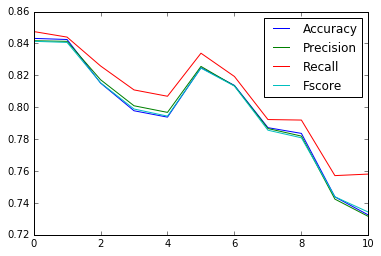

In [8]:
#with open('cvReadings.dat','r') as f:
#    cv_readings = cPickle.load(f)

dt = pd.DataFrame(cv_readings,index = alpha_ranges,columns = ["Accuracy","Precision","Recall","Fscore"])
print dt
dt.plot()

Now we train the model using the chosen alpha value (0) for several subset sizes. To evaluate the random prototype method, we perform 20 trials of random prototype selection for each subset size and evaluate each on the test set. We use accuracy and Fscore as metrics to evaluate the resulting classifier. The accuracy and Fscore are plotted against subset size to show the trends. Boxplots are used for the random subset method to make statistically significant deviations from the proposed method easier to see (Although this is not by itself a hypothesis test). Results are stored on disk by pickling the readings for future reference. 

In [10]:
readings = []
s.clear_solution()

soln = namedtuple("soln",["sopt","fopt"])
sol_optim = soln(copy.deepcopy(s),0)

for subset_size in [50,100,200,500,1000,5000]:

    print "Starting model learning"
    sol_optim = fmax_submodular(objective_function,range(len(train_set[1])),fprime = grad,sopt = sol_optim.sopt,k=subset_size,args = (7),verbose = True)
    pred_test = predict(sol_optim.sopt,test_x)
    
    ac = metrics.accuracy_score(pred_test,test_set[1])
    pr = metrics.precision_recall_fscore_support(pred_test,test_set[1],average="macro")
    vlist = list(pr)
    vlist = ["Optim",ac,subset_size] + vlist[0:-1]
    readings.append(vlist)
    
    print "Done with model learning"
    
    trials = 0
    while trials<20:
        randomIndices = np.random.randint(0,len(train_set[1]),subset_size)
        s.clear_solution()
        map(s.append,randomIndices)
        pred_test = predict(s,test_x)

        ac = metrics.accuracy_score(pred_test,test_set[1])
        pr = metrics.precision_recall_fscore_support(pred_test,test_set[1],average="macro")
        vlist = list(pr)
        vlist = ["Random",ac,subset_size] + vlist[0:-1]
        readings.append(vlist)
        trials += 1
        
    print "Random model evaluation done"

with open('Readings.dat','w') as f:
    cPickle.dump(readings,f)

Starting model learning
102.040816% done; Value of objective: 714.994360

Done with model learning
Random model evaluation done
Starting model learning
101.010101% done; Value of objective: 6.103040

Done with model learning
Random model evaluation done
Starting model learning
100.502513% done; Value of objective: 5.212420

Done with model learning
Random model evaluation done
Starting model learning
100.200401% done; Value of objective: 6.116520

Done with model learning
Random model evaluation done
Starting model learning
100.100100% done; Value of objective: 4.227220

Done with model learning
Random model evaluation done
Starting model learning
100.020004% done; Value of objective: 10.766660

Done with model learning
Random model evaluation done


In [11]:
#with open('Readings.dat','r') as f:
#    readings = cPickle.load(f)
data = pd.DataFrame(readings,columns=['Algorithm','Accuracy','SubsetSize','Precision','Recall','Fscore'])
print data

    Algorithm  Accuracy  SubsetSize  Precision    Recall    Fscore
0       Optim    0.7897          50   0.786323  0.796687  0.786360
1      Random    0.5634          50   0.559854  0.596960  0.547609
2      Random    0.5701          50   0.562246  0.590038  0.555089
3      Random    0.5803          50   0.576835  0.656134  0.573259
4      Random    0.5932          50   0.587879  0.645512  0.571024
5      Random    0.5804          50   0.578709  0.594723  0.567244
6      Random    0.5924          50   0.585062  0.662969  0.577712
7      Random    0.5848          50   0.580339  0.639820  0.566202
8      Random    0.6440          50   0.638068  0.679248  0.638455
9      Random    0.5825          50   0.576115  0.589499  0.555508
10     Random    0.5651          50   0.557475  0.618146  0.558342
11     Random    0.5538          50   0.547183  0.629379  0.538806
12     Random    0.5138          50   0.518669  0.558524  0.500236
13     Random    0.6054          50   0.600441  0.636013  0.58

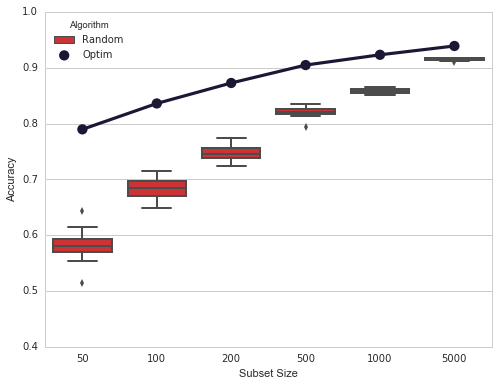

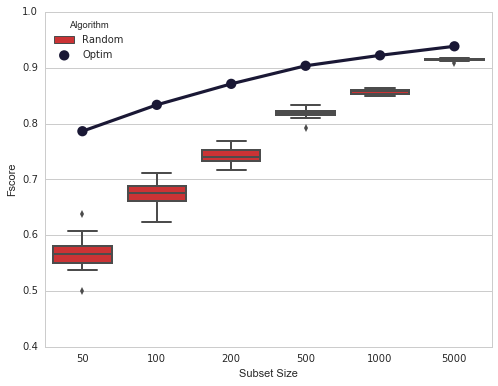

In [12]:
import seaborn as sns

sns.set_style("whitegrid")
#paper_rc = {'lines.linewidth': 1, 'lines.markersize': 10}                  
#sns.set_context("paper", rc = paper_rc) 
#sns.set_context("paper", font_scale=1.5, rc={"lines.linewidth": 1.5})

data_random = data[data['Algorithm']=='Random']
data_optim = data[data['Algorithm']=='Optim']

fig,ax = plt.subplots(figsize = (8,6))

sns.pointplot(y = "Accuracy",x = "SubsetSize",hue = "Algorithm",data = data_optim,ax = ax,palette = sns.color_palette("cubehelix", 8))
sns.boxplot(y="Accuracy",x = "SubsetSize",hue = "Algorithm",data = data_random,ax = ax,palette="Set1", linewidth=2)

ax.set(xlabel = 'Subset Size',ylabel = 'Accuracy')

plt.show()

fig,ax = plt.subplots(figsize = (8,6))

sns.pointplot(y = "Fscore",x = "SubsetSize",hue = "Algorithm",data = data_optim,ax = ax,palette = sns.color_palette("cubehelix", 8))
sns.boxplot(y="Fscore",x = "SubsetSize",hue = "Algorithm",data = data_random,ax = ax,palette="Set1", linewidth=2)

ax.set(xlabel = 'Subset Size',ylabel = "Fscore")

plt.show()

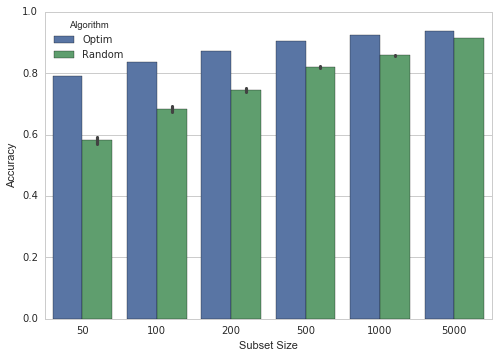

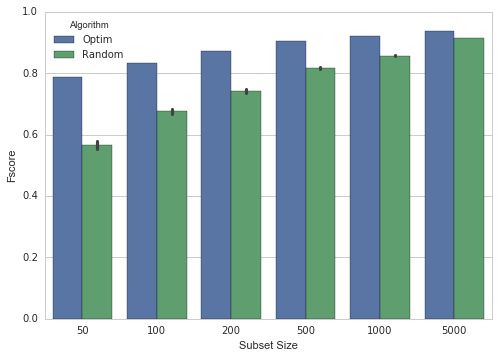

In [21]:
ax = sns.barplot(y="Accuracy",x="SubsetSize",hue="Algorithm",data=data)
ax.set(xlabel='Subset Size',ylabel = 'Accuracy')
plt.show()
ax = sns.barplot(y="Fscore",x="SubsetSize",hue="Algorithm",data=data)
ax.set(xlabel='Subset Size',ylabel = 'Fscore')
plt.show()

# Conclusions

* The proposed method outperforms random selection in terms of both measures in the regime of small number of prototypes.
* The performance improvement falls off as the number of prototypes selected is increased.  

This can be explained by the fact that random selection of prototypes inherently forms a model of the input distribution. As more prototypes are selected, they approximate the true input distribution better. This means that the nearest neighbor of a point generated from the true distribution is more likely to be of the same label. Our method although it selects prototypes intelligently, can only do as well as the true underlying distribution and hence both results converge as the number of points goes up. 

# Further Work

* Comparisons with other state of the art methods must be made to determine how good the method in comparison. 
* There are several avenues for parallelization eg. when populating the heap. Implementing these could speed up compute further.

From this study, I believe that significant performance improvements over random prototype selection can be observed in the cases where a small number of prototypes need to be selected (relative to the complexity of the input distribution). It is known in general that by solving an inherently simpler problem, discriminative classifiers can be estimated on smaller samples. So one approach I would like to explore is to include a discriminative component in the cost while retaining some structure that could help optimize it. I have specifically looked so far into submodularity although more general structure can be considered. 